<a href="https://colab.research.google.com/github/akash092/AI_Healthcare/blob/master/HW5_SLT/HW_mortality_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In-Hospital Mortality Prediction

# Step 0: BigQuery authentication


In [1]:
!pip install --quiet google-cloud-bigquery

# Import libraries
from google.cloud import bigquery
from google.colab import auth

# Authenticate your Google account
auth.authenticate_user()

# Set up BigQuery client (use your GCP project ID)
project_id = 'akashapiplayground'  # Replace with your actual project ID
client = bigquery.Client(project=project_id)

# Step 1: Load Data


In [2]:
query = """

  SELECT
  a.subject_id,
  a.hadm_id,
  CASE
    WHEN a.deathtime IS NOT NULL AND a.deathtime BETWEEN a.admittime AND a.dischtime THEN 1
    ELSE 0
  END AS mortality,
  a.admittime,
  a.dischtime,
  p.gender,
  FLOOR(DATE_DIFF(a.admittime, p.dob, YEAR)) AS age
FROM `physionet-data.mimiciii_clinical.admissions` a
JOIN `physionet-data.mimiciii_clinical.patients` p
ON a.subject_id = p.subject_id
WHERE a.admittime < a.dischtime
  """

query_job = client.query(query)
mortality_df = query_job.to_dataframe()

In [3]:
query = """

  WITH labs_filtered AS (
  SELECT
    le.subject_id,
    le.hadm_id,
    le.charttime,
    le.itemid,
    le.valuenum,
    a.admittime
  FROM `physionet-data.mimiciii_clinical.labevents` le
  JOIN `physionet-data.mimiciii_clinical.admissions` a
    ON le.hadm_id = a.hadm_id
  WHERE le.valuenum IS NOT NULL
    AND DATETIME_DIFF(le.charttime, a.admittime, HOUR) BETWEEN 0 AND 24
    AND le.itemid IN (50862, 50868, 50882)  -- Creatinine, WBC, Lactate
)

SELECT
  hadm_id,
  MAX(CASE WHEN itemid = 50862 THEN valuenum ELSE NULL END) AS creatinine_max,
  MAX(CASE WHEN itemid = 50868 THEN valuenum ELSE NULL END) AS wbc_max,
  MAX(CASE WHEN itemid = 50882 THEN valuenum ELSE NULL END) AS lactate_max
FROM labs_filtered
GROUP BY hadm_id
  """

query_job = client.query(query)
labs_df = query_job.to_dataframe()

In [4]:
query = """

  WITH vitals_filtered AS (
  SELECT
    ce.subject_id,
    ce.hadm_id,
    ce.charttime,
    ce.itemid,
    ce.valuenum,
    a.admittime
  FROM `physionet-data.mimiciii_clinical.chartevents` ce
  JOIN `physionet-data.mimiciii_clinical.admissions` a
    ON ce.hadm_id = a.hadm_id
  WHERE ce.valuenum IS NOT NULL
    AND DATETIME_DIFF(ce.charttime, a.admittime, HOUR) BETWEEN 0 AND 24
    AND ce.itemid IN (211, 220045, 220179, 220180)  -- HR, SBP, DBP, Temp
)

SELECT
  hadm_id,
  AVG(CASE WHEN itemid = 211 THEN valuenum ELSE NULL END) AS hr_avg,
  AVG(CASE WHEN itemid = 220045 THEN valuenum ELSE NULL END) AS sbp_avg,
  AVG(CASE WHEN itemid = 220179 THEN valuenum ELSE NULL END) AS dbp_avg,
  AVG(CASE WHEN itemid = 220180 THEN valuenum ELSE NULL END) AS temp_avg
FROM vitals_filtered
GROUP BY hadm_id
  """

query_job = client.query(query)
vitals_df = query_job.to_dataframe()

# Step 2: Prepare data for training

In [5]:
# Merge all on hadm_id
df = mortality_df.merge(labs_df, on="hadm_id", how="left")
df = df.merge(vitals_df, on="hadm_id", how="left")

# Drop missing outcome
df = df.dropna(subset=["mortality"])
df = df[df["age"] < 120]  # Remove outliers

# Encode gender
df["gender"] = df["gender"].map({"M": 1, "F": 0})

# Features and label
features = ["age", "gender", "creatinine_max", "wbc_max", "lactate_max", "hr_avg", "sbp_avg", "dbp_avg", "temp_avg"]
X = df[features]
y = df["mortality"]

In [7]:
# Print mortalitiy distribution
label_counts = y.value_counts(normalize=True) * 100

print("Label distribution (%):")
print(f"{label_counts=}")

Label distribution (%):
label_counts=mortality
0    90.783394
1     9.216606
Name: proportion, dtype: Float64


# Step 3: Train XGBoost

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

In [8]:
# Handle missing (optional: fill with median)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     10217
         1.0       0.45      0.09      0.15      1037

    accuracy                           0.91     11254
   macro avg       0.68      0.54      0.55     11254
weighted avg       0.87      0.91      0.88     11254

ROC AUC: 0.7782607768227912


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:14:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Step 4: Interpret Model

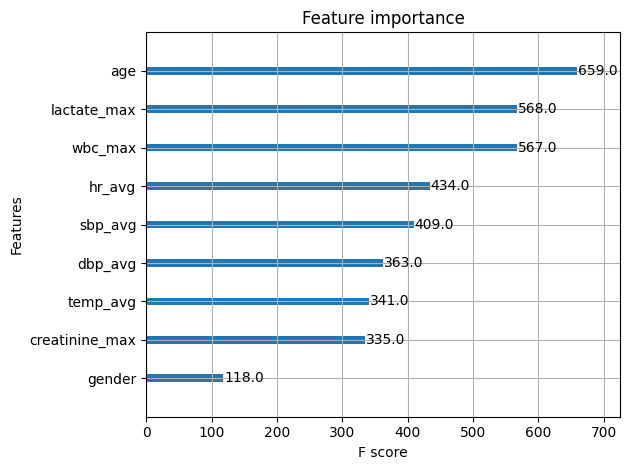

In [9]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

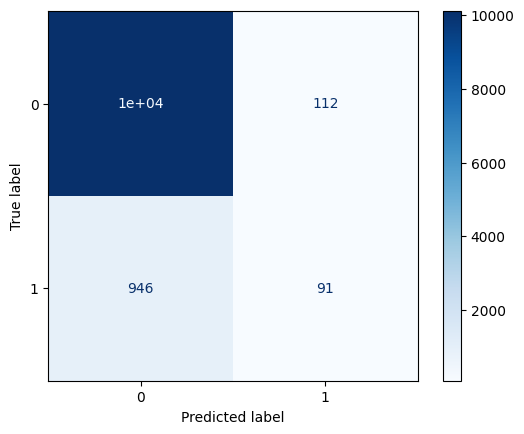

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Create the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)  # You can customize the colormap
plt.show()

# Step 3: Class Imbalance Handling

In [38]:
# Compute weight as ratio of classes
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale = neg / pos

# Handle imbalance
model_scaled = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale
)

In [39]:
model_scaled.fit(X_train, y_train)

y_prob = model_scaled.predict_proba(X_test)[:, 1]
y_pred_adj = model_scaled.predict(X_test)


print(classification_report(y_test, y_pred_adj))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85     10217
         1.0       0.21      0.62      0.32      1037

    accuracy                           0.76     11254
   macro avg       0.58      0.70      0.58     11254
weighted avg       0.88      0.76      0.80     11254

ROC AUC: 0.7632815351425655


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:39:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


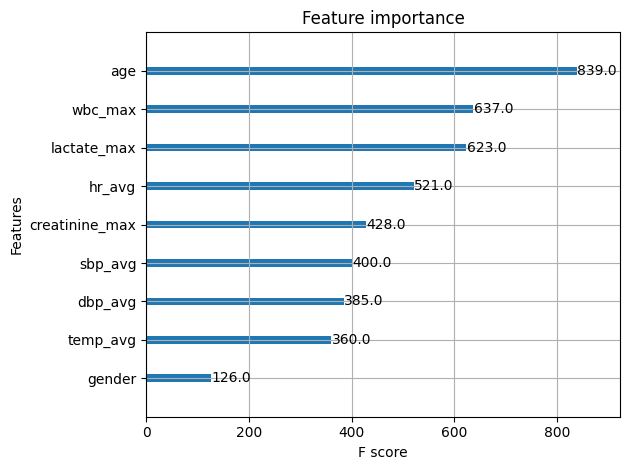

In [40]:
import matplotlib.pyplot as plt
xgb.plot_importance(model_scaled)
plt.tight_layout()
plt.show()

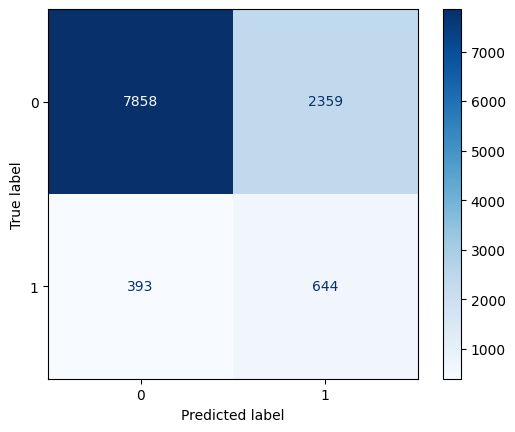

In [41]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_adj, labels=model_scaled.classes_)

# Create the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_scaled.classes_)
disp.plot(cmap=plt.cm.Blues)  # You can customize the colormap
plt.show()

# Step 4: Compute precision-recall-threshold curve

In [42]:
from sklearn.metrics import precision_recall_curve, f1_score

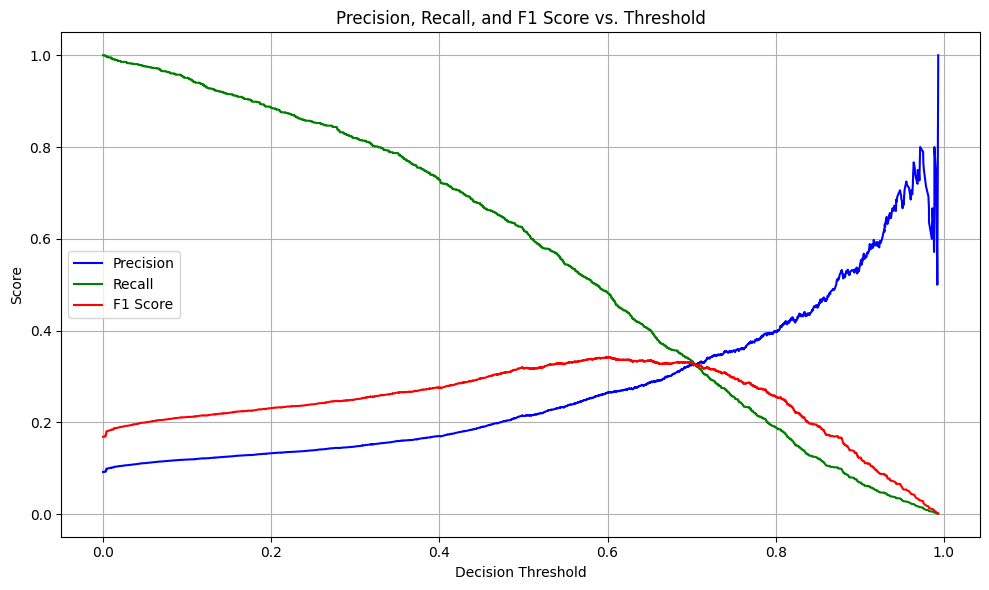

In [43]:
# Compute precision-recall-threshold curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero

# Plot everything
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='r')

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Find Best Threshold Numerically

In [44]:
import numpy as np

In [45]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.2f} with F1 Score: {f1_scores[best_idx]:.3f}")

Best Threshold: 0.60 with F1 Score: 0.343


In [46]:
y_pred_custom = (y_prob > best_threshold).astype(int)

In [47]:
print(classification_report(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90     10217
         1.0       0.27      0.48      0.34      1037

    accuracy                           0.83     11254
   macro avg       0.60      0.67      0.62     11254
weighted avg       0.88      0.83      0.85     11254

ROC AUC: 0.7632815351425655


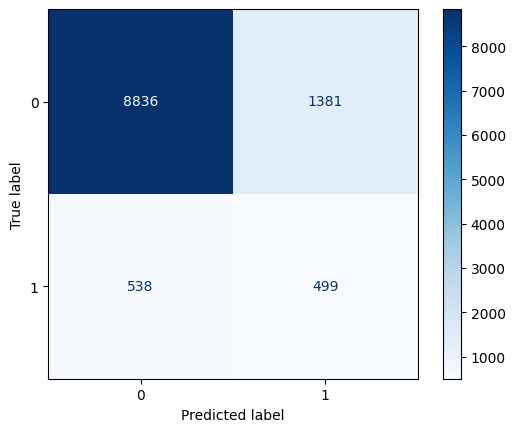

In [48]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_custom, labels=model_scaled.classes_)

# Create the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_scaled.classes_)
disp.plot(cmap=plt.cm.Blues)  # You can customize the colormap
plt.show()

# Step 6 : Enrich feature set with Charlson comorbidity categories

In [51]:
query = """
SELECT hadm_id, icd9_code
FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  """

query_job = client.query(query)
diagnoses = query_job.to_dataframe()

# clean up ICD-9 formatting if needed
diagnoses['icd9_code'] = diagnoses['icd9_code'].astype(str).str.replace('.', '')

In [57]:
!pip install shap

In [58]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(model_scaled)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

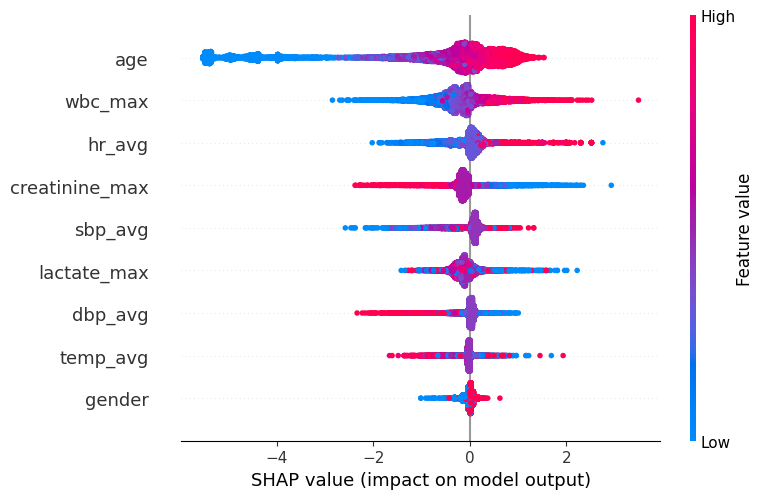

In [59]:
# Summary plot: shows top features and their global impact
shap.summary_plot(shap_values, X_test)

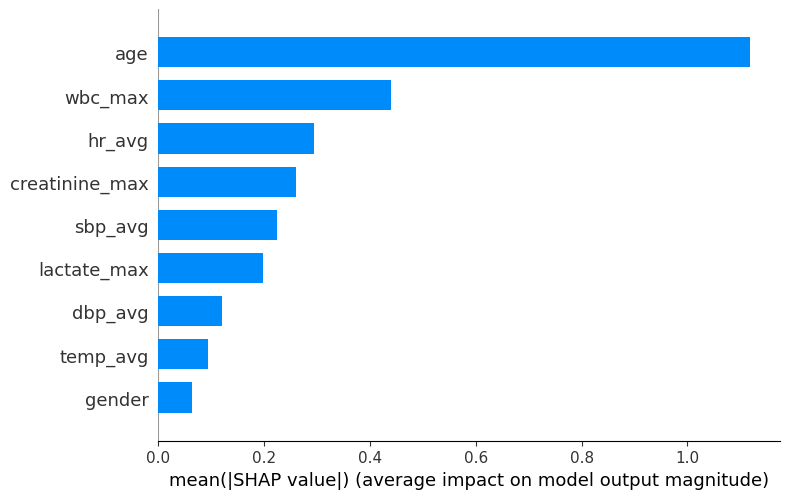

In [60]:
shap.summary_plot(shap_values, X_test, plot_type="bar")